# Importing Libraries

In [15]:
import glob
import random
import os
import math
import itertools
import sys

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from PIL import Image
import argparse# Importing Libraries

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable

from torchvision.models import vgg19

In [16]:
from ECV_Generator import *
from Feature_extractor import *
from Discriminator import *
from util import *

# Image Dataset

- Set the batch_size according to your computation power.

In [17]:
batch_size = 4
n_cpu = 0
out_channels = 3

class ImageDataset(Dataset):
    def __init__(self, root, transform): #, shape):
        #height, width = shape
        self.transform = transform

        self.files = sorted(glob.glob(root + "/*.*"))

    def __getitem__(self, index):
        
        black_path = self.files[index % len(self.files)]
        color_path = black_path.replace('black','color')
        
        img_black = np.asarray(Image.open(black_path))
        if(img_black.ndim==2):
            img_black = np.tile(img_black[:,:,None],3)
        (tens_l_orig, tens_l_rs) = preprocess_img(img_black, HW=(400, 400))
        #img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
        #img_black = self.transform(img_black)
        
        
        img_color = Image.open(color_path)
        img_color = self.transform(img_color)

        return {"black": tens_l_rs.squeeze(0), 'orig': tens_l_orig.squeeze(0), "color": img_color}


    def __len__(self):
        return len(self.files)
root = 'data/train_black/'

transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
dataloader = DataLoader(
    ImageDataset(root, transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

torch.Size([400, 400, 1])


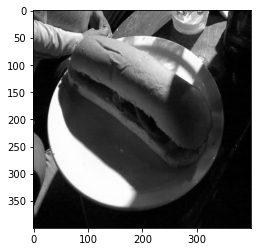

torch.Size([400, 400, 1])


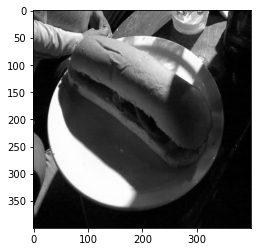

torch.Size([400, 400, 1])


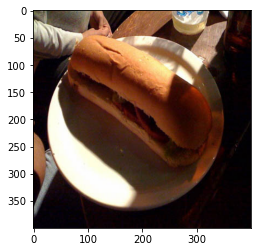

In [18]:
dataiter = iter(dataloader)
data = dataiter.next()

i = 1
img = data['black'][i].permute(1, 2, 0)
print(img.shape)
t = np.zeros((400, 400, 3))
t[..., 0] = img[..., 0]
t = color.lab2rgb(t)
plt.imshow(t)
plt.show()

img = data['orig'][i].permute(1, 2, 0)
print(img.shape)
t = np.zeros((400, 400, 3))
t[..., 0] = img[..., 0]
t = color.lab2rgb(t)
plt.imshow(t)
plt.show()

print(img.shape)
img = data['color'][i].permute(1, 2, 0)
plt.imshow(img)
plt.show()

# Training

In [19]:
os.makedirs("colorit_gan/images", exist_ok=True)
os.makedirs("colorit_gan/saved_models", exist_ok=True)

- Set start_epoch to the last epoch no. upto which you have trained or you can set it to our pretrained models and train it further.

In [20]:
start_epoch = 0
n_epochs= 50

lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 100
in_channels = 1
out_channels = 3
sample_interval = 100
checkpoint_interval = 1

cuda = torch.cuda.is_available()

In [21]:
shape = (400, 400)

# Initialize generator and discriminator
generator = color_ecv(in_channels = 3)
discriminator = Discriminator(input_shape=(out_channels, *shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

In [22]:
if start_epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("colorit_gan/saved_models/generator_"+str(start_epoch-1)+".pth"))
    discriminator.load_state_dict(torch.load("colorit_gan/saved_models/discriminator_"+str(start_epoch-1)+".pth"))

In [23]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [24]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Training

In [25]:
# ----------
#  Training
# ----------

for epoch in range(start_epoch, n_epochs):
    for i, imgs in enumerate(dataloader):

        # imgs_black : Light Channel of the Image in Model Shape
        # imgs_black_orig : Light Channel of the Image in Original Image Shape
        # imgs_color : Colourfull Image Provided 
        # gen_ab : A and B channel generated by the generator
        # gen_color : Colourfull Image generated by the Generator after postprocessing
        
        
        # Configure model input
        imgs_black = Variable(imgs["black"].type(Tensor))
        imgs_black_orig = Variable(imgs["orig"].type(Tensor))
        imgs_color = Variable(imgs["color"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_black.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_black.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_ab = generator(imgs_black)
        gen_color = postprocess_tens_new(imgs_black_orig, gen_ab)
        if cuda:
            gen_color = torch.from_numpy(gen_color).to('cuda')

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_color), valid)

        # Content loss
        gen_features = feature_extractor(gen_color.detach())
        real_features = feature_extractor(imgs_color.detach())
        loss_content = criterion_content(gen_features, real_features.detach())

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_color), valid)
        loss_fake = criterion_GAN(discriminator(gen_color.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), loss_D.item(), loss_G.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            # Save image grid with upsampled inputs and SRGAN outputs
            #imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_color = make_grid(gen_color.detach(), nrow=1, normalize=True)
            imgs_black_orig = make_grid(imgs_black_orig, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_black_orig, gen_color), -1)
            save_image(img_grid, "./colorit_gan/images/%d.png" % batches_done, normalize=False)

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "./colorit_gan/saved_models/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), "./colorit_gan/saved_models/discriminator_%d.pth" % epoch)

RuntimeError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 6.00 GiB total capacity; 4.17 GiB already allocated; 1.62 MiB free; 4.21 GiB reserved in total by PyTorch)